# Set up

In [481]:
import pandas as pd
import datetime
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
import pymc as pm
import matplotlib.pyplot as plt

In [482]:
def upload_and_clean(file_paths: list, years: list, quarters: list):
  dfs = {file_path: pd.read_csv(file_path) for file_path in file_paths}

  for (file_path, df), year, quarter in zip(dfs.items(), years, quarters):
    df['Registration Date'] = pd.to_datetime(
        df['Registration Date'],
        errors='coerce',
        dayfirst=True
    )

    df = df.dropna(subset=['Registration Date']).copy()

    df['Registration Date'] = df['Registration Date'].apply(
        lambda dt: dt.replace(year=year) if dt.year % 100 != year % 100 else dt
    )

    df['Student Name'] = df['Student First Name'] + ' ' + df['Student Last Name']

    df['Quarter'] = quarter

    dfs[file_path] = df

  combined = pd.concat(dfs.values(), ignore_index=True)

  return combined

In [483]:
paths = [
    '/content/Enrollment data for Sophie G(Q2 2025).csv',
    '/content/Enrollment data for Sophie G(Q2 2024).csv',
    '/content/Enrollment data for Sophie G(Q3 2025).csv',
    '/content/Enrollment data for Sophie G(Q3 2024).csv'
]

years = [2025, 2024, 2025, 2024]

quarters = ['Q2','Q2','Q3','Q3']

In [484]:
### CHOOSE DATA SET ###

enroll = upload_and_clean(paths, years, quarters)

/tmp/ipython-input-2114716921.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-2114716921.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-2114716921.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-2114716921.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [485]:
### INITIALIZE VARIABLES ###

MIN_SIZE = 3 # will not run class with fewer than 3 students
MAX_DAYS_BUCKET = 15

# Filtering

In [486]:
# Last 3-4 digits of every class name is the date it took place (eg. 730 is July 30).
# We filter out classes without digits at the end because we need class dates.

def is_valid_class(df: pd.DataFrame) -> pd.Series:
  return (
    df['Product/Class'].str.contains('SAT PREP|ACT PREP|WORKSHOP|COURSE',case=False) &
    df['Product/Class'].str[-3:].str.isdigit()
  )

In [487]:
def extract_class_date(class_name: str, year: int):
  """
  Extract day and month from end of class name.
  Given year, month, day in form "730" or "1129", gives "7-30-2025".
  """
  day = class_name[-2:]
  month = class_name[-4:-2]
  monthday = date(int(year),int(month),int(day))
  return monthday

In [488]:
classes = enroll[is_valid_class(enroll)].copy()

In [489]:
# Registration year assumed to be class year
def date_difference(df: pd.DataFrame):
  df['Year'] = df['Registration Date'].map(lambda x: x.year)

  df['Class date'] = df.apply(
    lambda row: extract_class_date(row['Product/Class'], row['Year']),
    axis = 1 # 1 is to apply to each row instead of each column
  )

  # Calculating time difference in days
  df['Class date'] = pd.to_datetime(df['Class date'])
  df['Registration Date'] = pd.to_datetime(df['Registration Date'])

  df['Days before class'] = (
    df['Class date'] - df['Registration Date']
  ).dt.days

  return df

In [490]:
classes = date_difference(classes)

In [491]:
# filtering out negative values
valid_classes = classes[~(classes['Days before class'] < 0)].copy()

In [492]:
print(len(valid_classes['Product/Class'].unique())) # number of classes
print(len(valid_classes)) # number of students

135
680


# Creating days before class count

In [493]:
# Gives number of registrations X days before class.
def build_days_before(df: pd.DataFrame) -> dict:
    result = {}

    for class_id in range(1,len(df['Product/Class'].unique())+1):
        result[class_id] = (
            df[df['Product/Class'] == df['Product/Class'].unique()[class_id-1]]
            .groupby('Days before class')
            .agg(Students = ('Student Name', 'count'),Quarter = ('Quarter', 'first'))
            .reset_index()
        )

    return result

In [494]:
days_before_class = build_days_before(valid_classes)

In [495]:
print(days_before_class[10])

   Days before class  Students Quarter
0                  1         1      Q2
1                  8         1      Q2
2                  9         1      Q2
3                 16         1      Q2


# Bucketing days

In [496]:
# We only consider the two weeks leading up to class date -- cap at 15 days.
def bucket_days(df: pd.DataFrame, days_bucket: int) -> pd.DataFrame:
  df = df.copy()

  df['Days before class'] = (
     df['Days before class']
     .clip(lower=0, upper=days_bucket)
  )

  return df

In [497]:
for class_name in days_before_class:
  days_before_class[class_name] = bucket_days(days_before_class[class_name],
                                                               MAX_DAYS_BUCKET)

In [498]:
print(days_before_class[10])

   Days before class  Students Quarter
0                  1         1      Q2
1                  8         1      Q2
2                  9         1      Q2
3                 15         1      Q2


# Cumulative student counts

In [499]:
# Creating cumulative count of students registered X days before class date.
def build_cumulative_counts(df: pd.DataFrame, index_range: range, index_col: str) -> pd.DataFrame:
    grouped = (
        df.groupby(index_col)
          .agg(Students=('Students', 'sum'))
          .reindex(index_range, fill_value=0)
          .sort_index(ascending=False)
    )

    grouped['Quarter'] = df['Quarter'].iloc[0]

    grouped['Students'] = grouped['Students'].cumsum()

    return grouped

In [500]:
cum_days_before = {
    c: build_cumulative_counts(days_before_class[c], range(0, MAX_DAYS_BUCKET + 1), 'Days before class')
    for c in days_before_class
}

In [501]:
print(cum_days_before[10])

                   Students Quarter
Days before class                  
15                        1      Q2
14                        1      Q2
13                        1      Q2
12                        1      Q2
11                        1      Q2
10                        1      Q2
9                         2      Q2
8                         3      Q2
7                         3      Q2
6                         3      Q2
5                         3      Q2
4                         3      Q2
3                         3      Q2
2                         3      Q2
1                         4      Q2
0                         4      Q2


# Combining classes into one df

In [502]:
# Transposing so that weeks/days before are columns and rows are unique classes
def combine_classes(dfs: dict, index_range: range) -> pd.DataFrame:
   result = {
      i: [dfs[class_name].at[i, 'Students'] for class_name in dfs]
      for i in index_range
   }

   return pd.DataFrame(result)

In [503]:
print(cum_days_before[10]['Quarter'].iloc[1])

Q2


In [504]:
summary = combine_classes(cum_days_before, range(0, MAX_DAYS_BUCKET+1))
summary['Success'] = [0 if summary[0].iloc[i] < 3 else 1 for i in range(len(summary))]
# success is 1, failure is 0
summary['Class ID'] = cum_days_before.keys()
summary['Quarter'] = [cum_days_before[i]['Quarter'].iloc[0] for i in range(1,len(cum_days_before)+1)]

In [505]:
print(summary.head())

    0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  Success  \
0  12  12  12  12  12  11  11  11  11  10  10   9   9   8   8   8        1   
1   6   6   6   5   5   5   5   5   5   5   5   5   5   5   5   4        1   
2   2   2   2   2   2   1   1   1   1   0   0   0   0   0   0   0        0   
3   9   9   8   8   8   8   8   8   7   6   6   6   5   5   5   5        1   
4   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1        0   

   Class ID Quarter  
0         1      Q3  
1         2      Q3  
2         3      Q2  
3         4      Q3  
4         5      Q2  


In [506]:
print(summary['Success'].value_counts())

Success
1    88
0    47
Name: count, dtype: int64


# Frequentist/percentile approach

In [507]:
### FREQUENTIST APPROACH FOR EACH CLASS/DAY COMBINATION ###

def find_percentile(data: pd.Series, level: int) -> int:
  """
  Percentile is rounded down; [1,2,3,4,5] will give 2 for 45%.
  """
  sorted = data.sort_values().reset_index(drop=True)
  size = len(sorted) + 1

  percentile = max(math.floor(level / 100 * size),1)

  return sorted[percentile-1]

In [508]:
def build_percentiles(df: pd.DataFrame, level: int) -> pd.DataFrame:
  percentiles = []
  for day in range(0,MAX_DAYS_BUCKET+1):
    percentiles.append(find_percentile(df[day],level))

  perc_df = pd.DataFrame(percentiles, columns=[f'{level}th percentile class'])
  perc_df.index.name = 'Days before class'

  return perc_df

In [509]:
percentile5th = build_percentiles(summary[summary['Quarter'] == 'Q3'],5)

In [510]:
print(build_percentiles(summary,25))
# graph of percent of classes that had at least three by certain day before

                   25th percentile class
Days before class                       
0                                      2
1                                      2
2                                      2
3                                      2
4                                      1
5                                      1
6                                      1
7                                      1
8                                      1
9                                      1
10                                     1
11                                     1
12                                     1
13                                     1
14                                     1
15                                     1


In [511]:
def percent_successful(df: pd.DataFrame, student_count: int) -> pd.DataFrame:
  percents = []

  for i in range(1,MAX_DAYS_BUCKET+1): # day 0 is final class count
    successes = len(df[(df[0] >= MIN_SIZE) & (df[i] == student_count)])
    total = len(df[df[i] == student_count])
    if total == 0:
      percent_success = 0
    else:
      percent_success = round(successes / total, 2)
    percents.append(percent_success)

  return percents

In [512]:
percent_success_zero_students = percent_successful(summary, student_count = 0)
percent_success_one_student = percent_successful(summary, student_count = 1)
percent_success_two_students = percent_successful(summary, student_count = 2)

In [513]:
print(percent_success_zero_students) # just not enough data -- 1/2 is 50% even though only two classes have 0 at that time
print(percent_success_one_student)
print(percent_success_two_students)
# how do i make sure this is meaningful without getting more data?
# not enough classes with size = 0
# use beta prior to inform p(s|x=0)

[0, 0.0, 0.33, 0.25, 0.25, 0.17, 0.14, 0.14, 0.12, 0.11, 0.11, 0.11, 0.09, 0.17, 0.17]
[0.0, 0.04, 0.0, 0.03, 0.03, 0.09, 0.11, 0.11, 0.21, 0.25, 0.29, 0.33, 0.37, 0.38, 0.38]
[0.13, 0.17, 0.22, 0.35, 0.45, 0.56, 0.63, 0.66, 0.63, 0.65, 0.64, 0.65, 0.62, 0.67, 0.73]


In [514]:
def build_percent_above_min(df: pd.DataFrame) -> pd.DataFrame:
  """
  Percent of classes that are at class min by i days before class.
  """
  num_classes = len(df)
  percents = []
  ones = [1] * num_classes

  for day in range(0,MAX_DAYS_BUCKET+1):
    p = len(df[df[day] > MIN_SIZE - 1][day]) / num_classes
    percents.append(p)

  early_cancel_risk = [ones[i]-percents[i] for i in range(len(percents))]

  perc_df = pd.DataFrame({'Percent above minimum' : percents,
                          'Risk of erroneous cancellation' : early_cancel_risk})
  perc_df.index.name = 'Days before class'

  return perc_df

In [515]:
print(build_percent_above_min(summary))

                   Percent above minimum  Risk of erroneous cancellation
Days before class                                                       
0                               0.651852                        0.348148
1                               0.629630                        0.370370
2                               0.614815                        0.385185
3                               0.607407                        0.392593
4                               0.585185                        0.414815
5                               0.562963                        0.437037
6                               0.518519                        0.481481
7                               0.488889                        0.511111
8                               0.474074                        0.525926
9                               0.459259                        0.540741
10                              0.444444                        0.555556
11                              0.437037           

# Binning days to improve data sparsity

In [516]:
bins = ['1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15+']

summary_binned = pd.DataFrame(
    {
        bins[i]: summary[[(2*i+1),(2*i+2)]].max(axis=1)
        for i in range(len(bins)-1)
    }
)
summary_binned['15+'] = summary[15]

In [517]:
students_binned = summary_binned.mask(summary_binned <= 1, '0-1').map(lambda x: str(x))
summary_binned_str = summary_binned.map(lambda x: str(x))

In [518]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+
0   12   12   11   11    10      9      8    8
1    6    5    5    5     5      5      5    4
2    2    2    1    1     0      0      0    0
3    9    8    8    8     6      6      5    5
4    1    1    1    1     1      1      1    1


In [519]:
print(students_binned.head())

   1-2  3-4  5-6  7-8 9-10 11-12 13-14  15+
0   12   12   11   11   10     9     8    8
1    6    5    5    5    5     5     5    4
2    2    2  0-1  0-1  0-1   0-1   0-1  0-1
3    9    8    8    8    6     6     5    5
4  0-1  0-1  0-1  0-1  0-1   0-1   0-1  0-1


In [520]:
for df in [summary_binned_str, students_binned, summary_binned]:
  df['Final count'] = summary[0]
  df['Success'] = summary['Success']
  df['Class ID'] = summary['Class ID']
  df['Quarter'] = summary['Quarter']

In [521]:
print(summary_binned.head())

   1-2  3-4  5-6  7-8  9-10  11-12  13-14  15+  Final count  Success  \
0   12   12   11   11    10      9      8    8           12        1   
1    6    5    5    5     5      5      5    4            6        1   
2    2    2    1    1     0      0      0    0            2        0   
3    9    8    8    8     6      6      5    5            9        1   
4    1    1    1    1     1      1      1    1            1        0   

   Class ID Quarter  
0         1      Q3  
1         2      Q3  
2         3      Q2  
3         4      Q3  
4         5      Q2  


In [522]:
print(students_binned.head())

   1-2  3-4  5-6  7-8 9-10 11-12 13-14  15+  Final count  Success  Class ID  \
0   12   12   11   11   10     9     8    8           12        1         1   
1    6    5    5    5    5     5     5    4            6        1         2   
2    2    2  0-1  0-1  0-1   0-1   0-1  0-1            2        0         3   
3    9    8    8    8    6     6     5    5            9        1         4   
4  0-1  0-1  0-1  0-1  0-1   0-1   0-1  0-1            1        0         5   

  Quarter  
0      Q3  
1      Q3  
2      Q2  
3      Q3  
4      Q2  


# Bayesian inference/Beta prior

In [523]:
# initializing prior constants (alpha/beta)
prior_strength = 2 # weak; eg., Beta(1,1) (uniform distribution) has prior strength 2
overall_success = summary['Success'].mean()
alpha = overall_success * prior_strength
beta = (1-overall_success) * prior_strength

In [524]:
def beta_success(df: pd.DataFrame, student_count: int) -> list:
  probabilities = []

  for i in range(0, len(bins)):
    successes = len(df[(df['Success'] == 1) & (df.iloc[:,i] == student_count)])
    failures = len(df[(df['Success'] == 0) & (df.iloc[:,i] == student_count)])
    post_alpha = alpha + successes
    post_beta = beta + failures

    # chance of success is ~Bin(n,p) where p~Beta(alpha+successes,beta+failures)
    # E[p] = (alpha + successes) / (alpha + beta + successes + failures)
    p_mean = round(post_alpha / (post_alpha + post_beta) * 100, 2)

    # ensure probabilities are monotonically decreasing
    if len(probabilities)>0 and p_mean < probabilities[-1]:
      probabilities.append(probabilities[-1])
    else:
      probabilities.append(p_mean)

  return probabilities

In [525]:
# probability of success for a class with X students N days before class
# where X is 0-1 or 2 and N is 1-2, 3-4, etc.
def build_prob_success(df: pd.DataFrame, student_counts: list):
  prob_success = pd.DataFrame({
      f'{student_count} students' : beta_success(df,student_count)
      for student_count in student_counts
  })

  add_zeros = pd.DataFrame([[0]*len(prob_success.columns)],columns=prob_success.columns)
  combined = pd.concat([add_zeros,prob_success],ignore_index=True)

  combined['Days before class'] = ['0'] + bins

  return combined

In [526]:
binned_prob_success = build_prob_success(students_binned,['0-1','2'])
unbinned_prob_success = build_prob_success(summary_binned_str,['0','1','2'])

In [527]:
print(binned_prob_success)
# still issues with probabilities increasing as days decrease

   0-1 students  2 students Days before class
0          0.00        0.00                 0
1          4.50       17.21               1-2
2          7.20       25.21               3-4
3          8.47       47.10               5-6
4         14.33       63.12               7-8
5         21.47       63.12              9-10
6         26.99       64.09             11-12
7         32.72       64.09             13-14
8         34.85       72.10               15+


# Logistic model

Idea is that you model the probability with logistic regression so that it doesn't show increases in success when students decrease -- assuming the constant beta_1 is what we expect, logistic model forces monotone decreasing probabilities.

First, we have to convert to long format so that we can use day bins as a variable.

In [528]:
summary_long = summary_binned.melt(
    id_vars = ['Final count','Success','Class ID'],
    value_vars = bins,
    var_name = 'Days before',
    value_name = 'Students'
)

In [529]:
print(summary_long.head())

   Final count  Success  Class ID Days before  Students
0           12        1         1         1-2        12
1            6        1         2         1-2         6
2            2        0         3         1-2         2
3            9        1         4         1-2         9
4            1        0         5         1-2         1


In [543]:
day_codes, day_idx = np.unique(summary_long['Days before'], return_inverse=True)

students = summary_long['Students'].values
success = summary_long['Success'].values

with pm.Model() as model:

  # hyperpriors
  beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
  beta_1 = pm.Normal('beta_1', mu=0, sigma=2)

  sigma_u = pm.HalfNormal('sigma_u', sigma=1)

  # creating random variable for intercepts for day buckets
  u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=len(day_codes))
  u = pm.Deterministic("u", u_raw * sigma_u)

  # model
  logit_p = beta_0 + u[day_idx] + beta_1 * students

  # likelihood
  p = pm.math.sigmoid(logit_p)
  y = pm.Bernoulli('y', p=p, observed=success)

  trace = pm.sample(
      target_accept=0.95,
      draws=2000,
      tune=2000
      )

Output()

ERROR:pymc.stats.convergence:There were 3593 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# very very bad result -- logistic model does not work

# Visualization

In [531]:
def plot_prob_success(df: pd.DataFrame):
  fig = go.Figure()

  for i in range(len(df.columns)-1):
    fig.add_trace(
      go.Scatter(
          x=df['Days before class'],
          y=df.iloc[:,i],
          mode='lines',
          name=df.columns[i]
      )
    )

  fig.update_layout(
      xaxis=dict(
          type='category',
          categoryorder='array',
          categoryarray=df['Days before class']
      ),
      yaxis=dict(
          title='Percent chance of success',
          range=[0, 100]
      ),
      xaxis_title='Days before class'
  )

  fig.show()

In [532]:
plot_prob_success(binned_prob_success)

In [533]:
def plot_for_slides(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(8, 4.5))

    x = df["Days before class"]

    for col in df.columns:
        if col == "Days before class":
            continue
        ax.plot(x, df[col], linewidth=2, label=col)

    # Labels and limits
    ax.set_xlabel("Days before class")
    ax.set_ylabel("Percent chance of success")
    ax.set_ylim(0, 100)

    # Remove default padding so 0 aligns with the origin
    ax.margins(x=0, y=0)

    # Ensure x is treated as categorical but starts at 0
    ax.set_xlim(-0.0, len(x) - 1)

    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)

    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("success_probability.png", dpi=300, bbox_inches="tight")
    plt.close()

In [534]:
plot_for_slides(binned_prob_success)

# Exploratory data analysis/misc.

In [535]:
### EXPLORATORY DATA ANALYSIS ###

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_student_count(df: pd.DataFrame, x_max=20, y_max=10):
    count = df.groupby('Product/Class')['Student Name'].count()

    bins = np.arange(1, x_max + 2, 1)  # 1 to x_max inclusive

    plt.figure()
    plt.hist(count, bins=bins)

    plt.xlim(1, 15)
    plt.ylim(0, 30)
    plt.xticks(np.arange(1, 15 + 1, 1))
    plt.yticks(np.arange(0, 30 + 1, 1))

    plt.xlabel("Students per class")
    plt.ylabel("Number of classes")
    plt.title("Distribution of Student Counts")

    plt.tight_layout()
    plt.savefig('student_counts.png', dpi=300, bbox_inches="tight")

    plt.show()

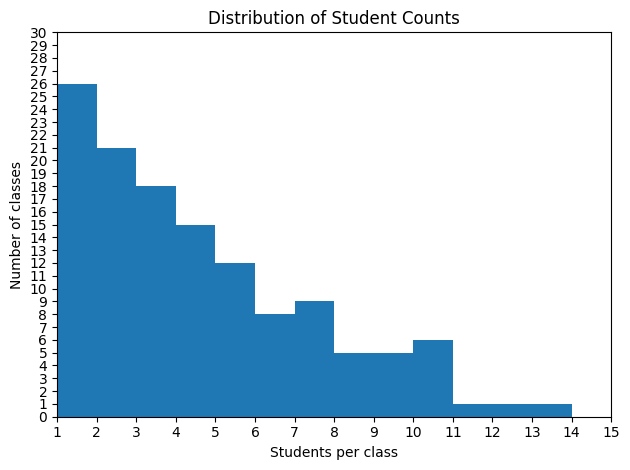

In [536]:
plot_student_count(valid_classes)

In [537]:
stats_days = summary.describe().T

In [538]:
# How many classes of each type occurred in Q3?
# 1st row is # classes, 2nd row is # students taking a class of that type

def build_class_breakdown(df: pd.DataFrame) -> pd.DataFrame:
    class_count = [
        sum(df['Product/Class']
            .value_counts()
            .index
            .str.contains(i,case=False))
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    student_count = [
        len(df[df['Product/Class']
                          .str.contains(i,case=False)])
        for i in ['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE']
    ]

    result = pd.DataFrame([class_count,student_count],
                                   columns=['SAT PREP', 'ACT PREP', 'WORKSHOP', 'COURSE'])

    return result

In [539]:
class_breakdown = build_class_breakdown(valid_classes)

In [540]:
print(class_breakdown) # none of the ACT prep classes have at least 3 students

   SAT PREP  ACT PREP  WORKSHOP  COURSE
0        85        11        31       8
1       504        21       128      27


In [541]:
# When do most students sign up for a class? (aggregated as a sum across all classes)

def plot_enrollment_agg(df: pd.DataFrame):
    fig = px.histogram(df['Days before class'])

    fig.update_layout(
        xaxis = dict(title = 'Days until class'),
        yaxis = dict(title = 'Number of students'),
        title = 'Distribution of Student Enrollment Times'
    )

    fig.show()

In [542]:
plot_enrollment_agg(valid_classes)